In [45]:
import pandas as pd
import numpy as np

About data:
EUROPEAN CLIMATE ASSESSMENT & DATASET (ECA&D), file created on 08-05-2023
THESE DATA CAN BE USED FREELY PROVIDED THAT THE FOLLOWING SOURCE IS ACKNOWLEDGED:

Klein Tank, A.M.G. and Coauthors, 2002. Daily dataset of 20th-century surface
air temperature and precipitation series for the European Climate Assessment.
Int. J. of Climatol., 22, 1441-1453.
Data and metadata available at http://www.ecad.eu

FILE FORMAT (MISSING VALUE CODE IS -9999):

01-06 SOUID: Source identifier
08-15 DATE : Date YYYYMMDD
17-21 TG   : mean temperature in 0.1 &#176;C
23-27 Q_TG : Quality code for TG (0='valid'; 1='suspect'; 9='missing')

This is the blended series of station GERMANY, BERLIN-TEMPELHOF (STAID: 2759).
Blended and updated with sources: 111448 127488 128124 
See file sources.txt and stations.txt for more info.

In [8]:
df = pd.read_csv("/Users/wukaiti/Spiced/my_encounter_notes/week_07/data/ECA_blended_custom/TG_STAID002759.txt",
    sep = ",",
    skiprows=19,
    skipinitialspace = True,
    parse_dates=[1])

In [7]:
dates

,SOUID,DATE,TG,Q_TG
0,127488,1876-01-01,22,0
1,127488,1876-01-02,25,0
2,127488,1876-01-03,3,0
3,127488,1876-01-04,-58,0
4,127488,1876-01-05,-98,0
...,...,...,...,...
53776,111448,2023-03-27,34,0
53777,111448,2023-03-28,35,0
53778,111448,2023-03-29,66,0
53779,111448,2023-03-30,117,0


Missing values

In [9]:
df_missing = df[df["Q_TG"]==9]

In [10]:
df_missing["DATE"].min()

Timestamp('1945-04-25 00:00:00')

In [11]:
df_missing["DATE"].max()

Timestamp('1945-11-05 00:00:00')

In [13]:
missing_days = (df_missing["DATE"].max()-df_missing["DATE"].min()).days +1
missing_days

195

In [17]:
missing_days == df_missing.shape[0]

True

Data imputation

In [18]:
# import relativedelta
from dateutil.relativedelta import *

In [19]:
# reference years are all years 5 years before and  5 years after
reference_years = list(range(-5,6))
reference_years.remove(0)
# function for clean temperature values
def clean_temp(df,x):
    """
    returns a temperaure column in celcius with missing values imputed;
    imputation is done with the average of the temperautes on the same
    day over all the reference years; division by 10 for celcius value
    """
    # if missing value occurs
    if x['Q_TG']==9:
        # list reference dates
        reference_dates = [x['DATE']+relativedelta(years=y) for y in reference_years]
        # mean temperatue over the references dates
        temp_value = df[df['DATE'].isin(reference_dates)]['TG'].mean()
        # division by 10 to convert to celcius value
        return int(temp_value)/10
    # else just division by 10 to convert to celcius value
    return x['TG']/10

In [20]:
# create clean temperatutre column
df['TEMP'] = df.apply(
    lambda x: clean_temp(df,x),
    axis=1
)

In [21]:
df

,SOUID,DATE,TG,Q_TG,TEMP
0,127488,1876-01-01,22,0,2.2
1,127488,1876-01-02,25,0,2.5
2,127488,1876-01-03,3,0,0.3
3,127488,1876-01-04,-58,0,-5.8
4,127488,1876-01-05,-98,0,-9.8
...,...,...,...,...,...
53776,111448,2023-03-27,34,0,3.4
53777,111448,2023-03-28,35,0,3.5
53778,111448,2023-03-29,66,0,6.6
53779,111448,2023-03-30,117,0,11.7


In [23]:
df.isna().sum()

SOUID    0
DATE     0
TG       0
Q_TG     0
TEMP     0
dtype: int64

Train-Test Split

In [24]:
#lowercase column name
df.columns = df.columns.str.lower()
#extract relevant time series
clean_df = df.set_index("date")[["temp"]]

In [25]:
clean_df

,temp
date,
1876-01-01,2.2
1876-01-02,2.5
1876-01-03,0.3
1876-01-04,-5.8
1876-01-05,-9.8
...,...
2023-03-27,3.4
2023-03-28,3.5
2023-03-29,6.6


In [29]:
len(df)*0.2

10756.2

In [32]:
# do train-test split
train = clean_df[:"2022-12-31"]
train.shape
test = clean_df["2023-01-01":]
test.shape

(90, 1)

In [33]:
train.shape, test.shape

((53691, 1), (90, 1))

In [37]:
train.to_csv("/Users/wukaiti/Spiced/my_encounter_notes/week_07/data/train.csv")
test.to_csv("/Users/wukaiti/Spiced/my_encounter_notes/week_07/data/test.csv")

### How to remove noise? Savistzky Golay Filter!
##### en.wikipedia.org/wiki/Savitzky-Golay_filter

In [43]:
from scipy.signal import savgol_filter

In [39]:
train

,temp
date,
1876-01-01,2.2
1876-01-02,2.5
1876-01-03,0.3
1876-01-04,-5.8
1876-01-05,-9.8
...,...
2022-12-27,4.2
2022-12-28,6.3
2022-12-29,10.0


In [51]:
train["denoised"] = savgol_filter(np.array(train["temp"]),30,3, mode="nearest")
train["noise"] = train["temp"] -train["signal"]

/var/folders/_3/95ys3_5j3m338xqx08t_py280000gn/T/ipykernel_24982/2865903371.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["denoised"] = savgol_filter(np.array(train["temp"]),30,3, mode="nearest")
/var/folders/_3/95ys3_5j3m338xqx08t_py280000gn/T/ipykernel_24982/2865903371.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["noise"] = train["temp"] -train["signal"]


<AxesSubplot:xlabel='date'>

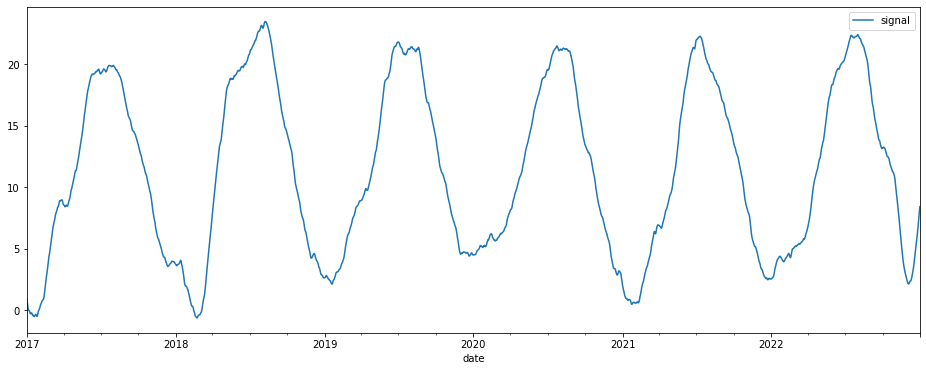

In [52]:
import matplotlib as plt
plt.rcParams["figure.figsize"] = (16,6)
train["signal"]["2017-01-01":"2022-12-31"].plot(legend=True)

<AxesSubplot:xlabel='date'>

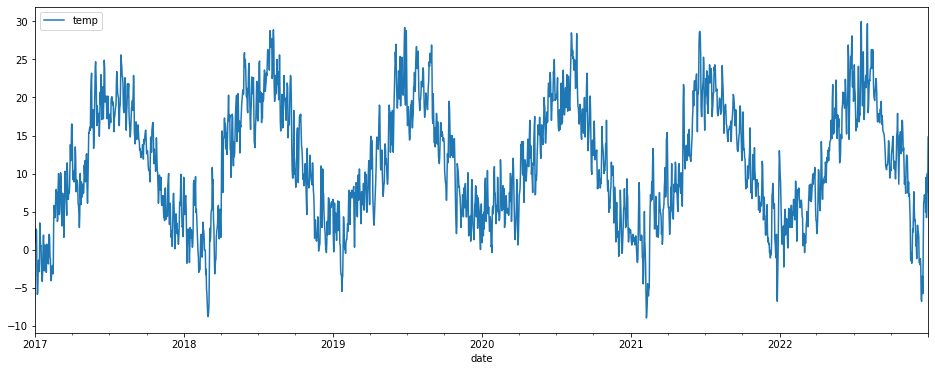

In [53]:
plt.rcParams["figure.figsize"] = (16,6)
train["temp"]["2017-01-01":"2022-12-31"].plot(legend=True)